In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=8)
  plt.grid(True)

def trend(time, slope=0):
  return time*slope

def seasonality_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(season_time*2*np.pi),
                  1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time+phase)%period)/period
  return amplitude*seasonality_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

***Trend + Seasonality + White noise***

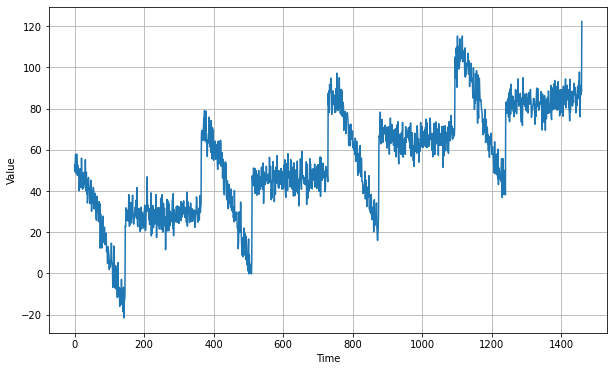

In [3]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

**Naive Forecast**

Considers the previous day series and forecasts it

In [5]:
naive_forecast = series[split_time-1:-1]

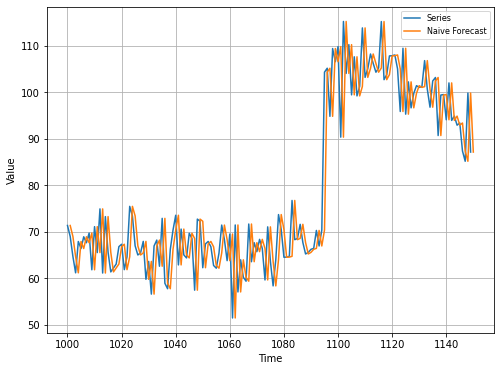

In [6]:
plt.figure(figsize=(8,6))
plot_series(time_valid, x_valid, start=0, end=150, label='Series')
plot_series(time_valid, naive_forecast, start=1, end=151, label='Naive Forecast')
plt.show()

***Evaluate***

In [7]:
import keras

In [8]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.937908515321673

In [9]:
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

5.9379085153216735

**Moving Average**
<blockquote>Forecast = training moving average of differenced series + centered moving average 
of past series (t-365)</blockquote>

In [12]:
# If window_size = 1, then this can be considered as naive forecast
def moving_average_forecast(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time+window_size].mean())
  return np.array(forecast)

In [15]:
#Faster method
def moving_average_forecast(series, window_size):
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size-1:-1]/window_size

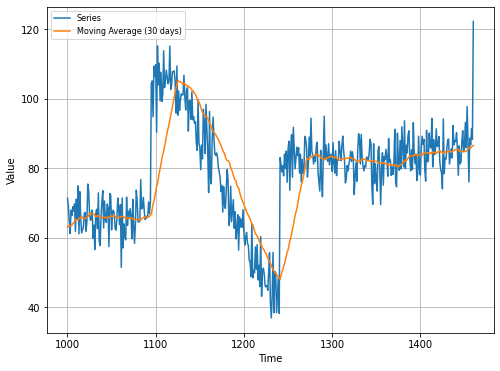

In [18]:
moving_avg = moving_average_forecast(series, 30)[split_time-30:]
plt.figure(figsize=(8,6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, moving_avg, label='Moving Average (30 days)')
plt.show()

This shows if the series is stable, the moving average gives a good prediction. However, for a seasonal change, the prediction is not so good.

In [19]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.1424185706207854

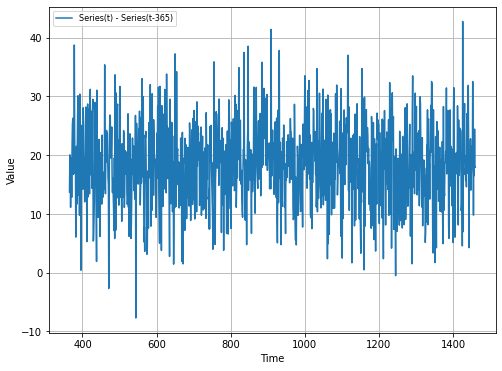

In [21]:
diff_series = (series[365:]-series[:-365])
diff_time = time[365:]

plt.figure(figsize=(8,6))
plot_series(diff_time, diff_series, label='Series(t) - Series(t-365)')
plt.show()

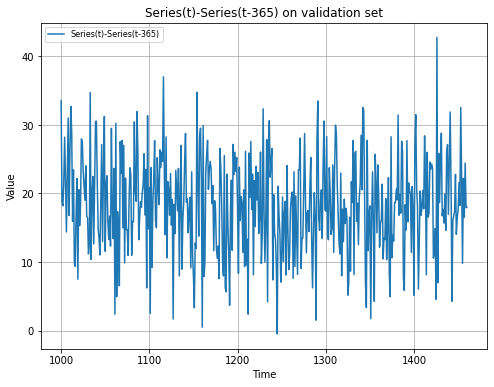

In [22]:
plt.figure(figsize=(8,6))
plot_series(time_valid, diff_series[split_time-365:], label='Series(t)-Series(t-365)')
plt.title('Series(t)-Series(t-365) on validation set')
plt.show()

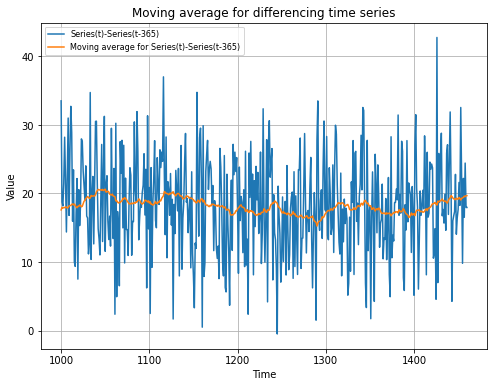

In [24]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time-365-50:]
plt.figure(figsize=(8,6))
plot_series(time_valid, diff_series[split_time-365:], label='Series(t)-Series(t-365)')
plot_series(time_valid, diff_moving_avg, label='Moving average for Series(t)-Series(t-365)')
plt.title('Moving average for differencing time series')
plt.show()

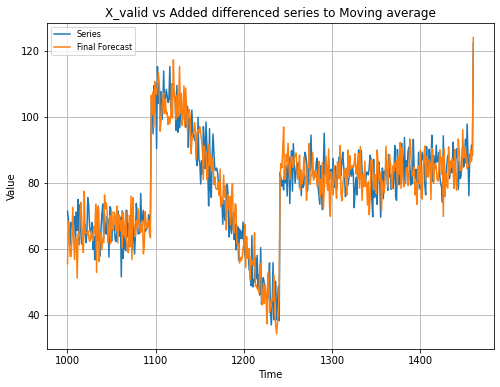

In [29]:
#Now the original time series need to be predicted with this moving average
diff_moving_avg_plus_past = series[split_time-365:-365] + diff_moving_avg
plt.figure(figsize=(8,6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, diff_moving_avg_plus_past, label='Final Forecast')
plt.title('X_valid vs Added differenced series to Moving average')
plt.show()

In [28]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.839310562995895

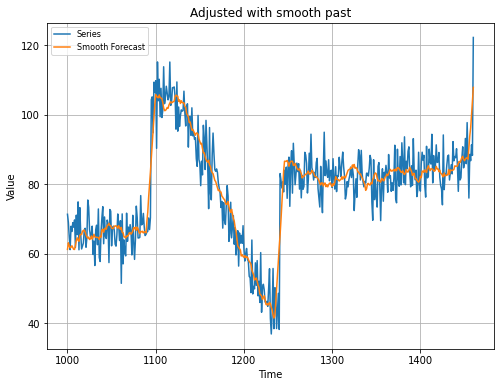

In [30]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time-370:-359], 11) + diff_moving_avg
plt.figure(figsize=(8,6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label='Smooth Forecast')
plt.title('Adjusted with smooth past')
plt.show()

In [31]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

4.566859958970771

This seems to have predicted better than all the previous approches